<a href="https://colab.research.google.com/github/VVlovsky/breast_cancer_logistic_regression/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regresja logistyczna do wyliczania prawdopodobienstwa recydywy nowotworu piersi. 

**Autorzy**: 
- Vyacheslav Trushkov
- Dmytro Kuzmin

**Motywacja**: napisanie algorytmu który po otrzymaniu zbioru dannych (286 instancji) zrobi predykcje możliwości recydywy raku.

**Dane**: używamy danych z Uniwersyteckiego Centrum Medycznego, Instytut Onkologii, Ljubljana, Jugosławia
- Rozmiar zbioru danych: 286
- Liczba atrybutów: 9

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sb
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import decomposition
from sklearn.model_selection import KFold
from scipy.io import loadmat
from scipy import stats


if not os.path.exists('./breast-cancer.data'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data
if not os.path.exists('./breast-cancer.names'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.names

In [ ]:
!cat './breast-cancer.names'

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [ ]:
raw_data = pd.read_csv('./breast-cancer.data', names=['class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']).sample(frac=1)
raw_data.head()

,class,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat
267,recurrence-events,60-69,ge40,20-24,24-26,yes,3,left,left_low,yes
75,no-recurrence-events,50-59,ge40,10-14,0-2,no,1,left,left_low,no
246,recurrence-events,30-39,premeno,15-19,6-8,yes,3,left,left_low,yes
58,no-recurrence-events,60-69,ge40,30-34,0-2,no,1,left,left_up,no
79,no-recurrence-events,40-49,premeno,25-29,0-2,no,2,right,central,no


In [ ]:

dummies = pd.get_dummies(raw_data.menopause)
data = raw_data.join(dummies)
data = data.drop('menopause', axis=1)

dummies = pd.get_dummies(data.breast_quad)
data = data.join(dummies)
data = data.drop('breast_quad', axis=1)
data = data.drop('?', axis=1)

data.node_caps = (data.node_caps == 'yes').astype(int)
data.irradiat = (data.irradiat == 'yes').astype(int)
data['class'] = (data['class'] == 'recurrence-events').astype(int)
data.breast = (data.breast == 'left').astype(int)

data.age = data.age.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))
data.tumor_size = data.tumor_size.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))
data.inv_nodes = data.inv_nodes.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))

y = np.asarray(data['class'].values)
data = data.drop('class', axis=1)

data = data.apply(lambda x: (x - x.min()) / ( x.max() - x.min()), axis=0)

data.head()

,age,tumor_size,inv_nodes,node_caps,deg_malig,breast,irradiat,ge40,lt40,premeno,central,left_low,left_up,right_low,right_up
267,0.8,0.4,1.00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75,0.6,0.2,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
246,0.2,0.3,0.25,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
58,0.8,0.6,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79,0.4,0.5,0.00,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
def find_most_correlated_cols(df):
  plt.figure(figsize=(10,10))
  sns.heatmap(df.corr(),annot = True, fmt = ".2f",cbar = True, vmin=-1, vmax =1)
  plt.xticks(rotation=90)
  plt.yticks(rotation = 0)

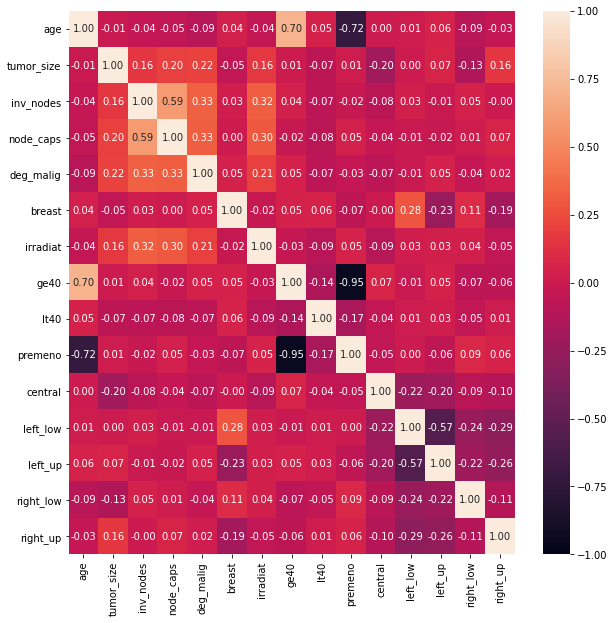

In [ ]:
find_most_correlated_cols(data)

In [ ]:
to_drop = ['premeno', 'ge40']
data = data.drop(to_drop, axis=1)

x = np.asarray(data.values)

In [ ]:
# pca = decomposition.PCA(n_components=3)
# pca.fit(x)
# x = pca.transform(x)

Dalej dzielimy dane na **dane testowe** i **dane uczące**. 

In [ ]:

clf = LogisticRegression(max_iter=1000)
grid={"C":np.logspace(-3,3,7), 
      "penalty":["l2"], 
      "solver":['newton-cg', 'lbfgs', 'liblinear']}
acc_arr = []


kf = KFold(n_splits=10)
for train_index, test_index in kf.split(x):
   x_train, x_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]
   clf_cv=GridSearchCV(clf,grid,cv=10)
   clf_cv.fit(x_train,y_train)
   print("tuned hpyerparameters :(best parameters) ",clf_cv.best_params_)
   
   acc_arr.append(clf_cv.score(x_test, y_test))
   print(f'Dokładność predykcji: {acc_arr[-1]*100:.2f}%')

print(f'Średnia dokładność predykcji: {np.mean(acc_arr)*100:.2f}%')


tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Dokładność predykcji: 68.97%
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 72.41%
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 65.52%
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 55.17%
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 65.52%
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 86.21%
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Dokładność predykcji: 85.71%
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Dokładność predykcji: 60.71%
tuned hpyerparameters :(

Budujemy tablice pomyłek

Tezą naszego badania było znależć z jakim prawdopodobieństwem rak piersi może się powrucić.

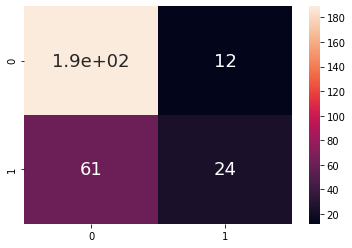

In [ ]:
y_pred = clf_cv.predict(x)
cm = confusion_matrix(y, y_pred)
sn.heatmap(cm, annot=True, annot_kws={"size": 18})
plt.show()